In [192]:
import numpy as np
import pandas as pd


## Data Cleaning (Backfilling NA)

In [193]:
df = pd.read_csv('ocean-acidification-munida-state-1998-2020.csv')

In [194]:
# Fill missing values with the average of the last recorded and next recorded value
def fill_missing_values(df):
    columns = df.columns
    # Iterate over each missing value
    for column in columns:
        for idx in df[df[column].isna()].index:
            # Find the last non-null value before the missing value
            prev_value = df[column].loc[:idx].dropna().iloc[-1] if not df[column].loc[:idx].dropna().empty else None
            
            # Find the first non-null value after the missing value
            next_value = df[column].loc[idx:].dropna().iloc[0] if not df[column].loc[idx:].dropna().empty else None
            
            if prev_value is not None and next_value is not None:
                # Calculate the average of the previous and next values
                avg_value = (prev_value + next_value) / 2
                df.at[idx, column] = avg_value  # Fill the missing value with the average
    #Drops all rows with empty values (which at this point would be just the last row)
    df = df.dropna()

    return df

In [195]:
df = df[['date','measure', 'data_value']]
#Creating a pivot table so that every measure has it's own column
pivoted_df = df.pivot(index='date',columns='measure', values='data_value')

#Some of the months have multiple entries, so to allow indexing based on month, we have to keep only one entry per month
pivoted_df.index = pd.to_datetime(pivoted_df.index).to_period('M')
#only keeping the first entry within the duplicated months
pivoted_df = pivoted_df.loc[~pivoted_df.index.duplicated(keep='first')]
#Converting the dates by to a full date, rather than just year/month
pivoted_df.index = pivoted_df.index.to_timestamp()

#Filling NaN values with the average of the last entry and the next entry
cleaned_df = fill_missing_values(pivoted_df)

#Reseting the date as a column rather than the index so that'll work in Streamlit
cleaned_df = cleaned_df.reset_index()

cleaned_df.to_csv('cleaned_ocean_data.csv', index=False)

## Decision Tree Model

In [196]:
df = pd.read_csv('cleaned_ocean_data.csv', index_col=0)
df.index = pd.to_datetime(df.index).to_period('M')
df.head(5)

,Aragonite saturation,Dissolved inorganic carbon,Hydrogen ion conc,Partial pressure CO2,Salinity,Salt water temperature,Total alkalinity,pH
date,,,,,,,,
1998-01,2.2400,2084.5,8.039500e-09,348.80,34.2680,10.5,2288.7,8.09480
1998-02,2.4060,2058.3,8.117000e-09,351.80,34.2940,12.9,2277.7,8.09060
1998-03,2.3930,2061.2,7.896400e-09,340.80,34.2550,12.0,2280.0,8.10260
1998-04,2.2005,2081.9,8.161500e-09,353.45,34.2895,10.3,2286.0,8.08845
1998-10,2.0080,2102.6,8.426600e-09,366.10,34.3240,8.6,2284.1,8.07430


In [211]:
#Trying it out with Decision Trees
df_trial = df['Partial pressure CO2']

In [212]:
import streamlit as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.base import ForecastingHorizon
from sklearn.tree import DecisionTreeRegressor, plot_tree

#Including some model parameters that can be included in the Streamlit App
criterion="squared_error",
splitter="best",
max_depth=15,
min_samples_split=5,
min_samples_leaf=2,
max_features="sqrt",
random_state=42

model_params = {
    "criterion":criterion,
    "splitter":splitter,
    "max_depth":max_depth,
    "min_samples_split":min_samples_split,
    "min_samples_leaf":min_samples_leaf
}

def manual_train_test_split(y, train_size):
    split_point = int(len(y) * train_size)
    return y[:split_point], y[split_point:]

def DecisionTree(y_train, y_test, fh, **params):
    #Prepping the data for decision trees
    #Creating dataframe for y_train, y_test to allow for lag columns
    y_train = y_train.to_frame('data_value')
    y_test = y_test.to_frame('data_value')

    #Creating lag variables for train
    y_train['Lag_1'] = y_train['data_value'].shift(1)
    y_train['Lag_2'] = y_train['data_value'].shift(2)
    y_train['Lag_3'] = y_train['data_value'].shift(3)
    #Dropping nulls
    y_train.dropna(inplace=True)

    #Creating lag variables for test
    y_test['Lag_1'] = y_test['data_value'].shift(1)
    y_test['Lag_2'] = y_test['data_value'].shift(2)
    y_test['Lag_3'] = y_test['data_value'].shift(3)
    #Dropping nulls
    y_test.dropna(inplace=True)

    X_train = y_train[['Lag_1','Lag_2','Lag_3']]
    y_train = y_train['data_value']

    X_test = y_test[['Lag_1','Lag_2','Lag_3']]
    y_test = y_test['data_value']

    
    dt_model = DecisionTreeRegressor(**params)
    dt_model.fit(X_train, y_train)

    
    return dt_model, X_test, y_test, X_train

def forecast_future(model, data, fh):
    # Initialize the list of forecasted values
    forecasted_values = []

    # Start with the last known lag values
    last_known_lags = data.iloc[-1, -3:].values  # Get the last 3 lags from the data

    for step in range(fh):
        # Convert the current lags into a DataFrame with appropriate column names
        current_lags_df = pd.DataFrame([last_known_lags], columns=[f'Lag_{i}' for i in range(1, 4)])

        # Predict the next value using the model
        next_value = model.predict(current_lags_df)[0]

        # Append the forecasted value
        forecasted_values.append(next_value)

        # Update the lag values for the next prediction
        last_known_lags = np.roll(last_known_lags, -1)  # Shift the lag values
        last_known_lags[-1] = next_value  # Replace the last lag with the predicted value

    return forecasted_values


def run_forecast(y_train, y_test, model, fh, **kwargs):
    if model == 'ETS':
        forecaster = AutoETS(**kwargs)
    elif model == 'ARIMA':
        forecaster = AutoARIMA(**kwargs)
    elif model == "Decision Tree":
        forecaster, X_test, y_test, X_train = DecisionTree(y_train, y_test, fh)
        #Keeping track of the index
        test_indices = X_test.index
        y_pred = forecaster.predict(X_test)
        #Combining the predicted values with the date index
        y_pred = pd.DataFrame({
            'Prediction': y_pred
        }, index = test_indices)
        #Getting the forecast
        last_date = y_test.index[-1]
        future_dates = pd.period_range(start=last_date + 1, periods=fh, freq=y_train.index.freq)
        future_horizon = ForecastingHorizon(future_dates, is_relative=False)
        forecasts = forecast_future(forecaster, X_test,fh)
        y_forecast = pd.DataFrame({
                "Forecasts": forecasts
        }, index=future_dates)
        
    else:
        raise ValueError("Unsupported model")
    
    if model != "Decision Tree":
        forecaster.fit(y_train)
        y_pred = forecaster.predict(fh=ForecastingHorizon(y_test.index, is_relative=False))
        
        last_date = y_test.index[-1]
        future_dates = pd.period_range(start=last_date + 1, periods=fh, freq=y_train.index.freq)
        future_horizon = ForecastingHorizon(future_dates, is_relative=False)
        y_forecast = forecaster.predict(fh=future_horizon)

    
    return forecaster, y_pred, y_forecast

def plot_time_series(y_train, y_test, y_pred, y_forecast, title):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(y_train.index.to_timestamp(), y_train.values, label="Train")
    ax.plot(y_test.index.to_timestamp(), y_test.values, label="Test")
    ax.plot(y_pred.index.to_timestamp(), y_pred.values, label="Test Predictions")
    ax.plot(y_forecast.index.to_timestamp(), y_forecast.values, label="Forecast")
    plt.legend()
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Value")
    return fig

In [213]:
y_train, y_test = manual_train_test_split(df_trial, train_size=.8)

In [214]:
dt_model, y_pred, y_forecast = run_forecast(y_train, y_test, 'Decision Tree',fh=24, **model_params)


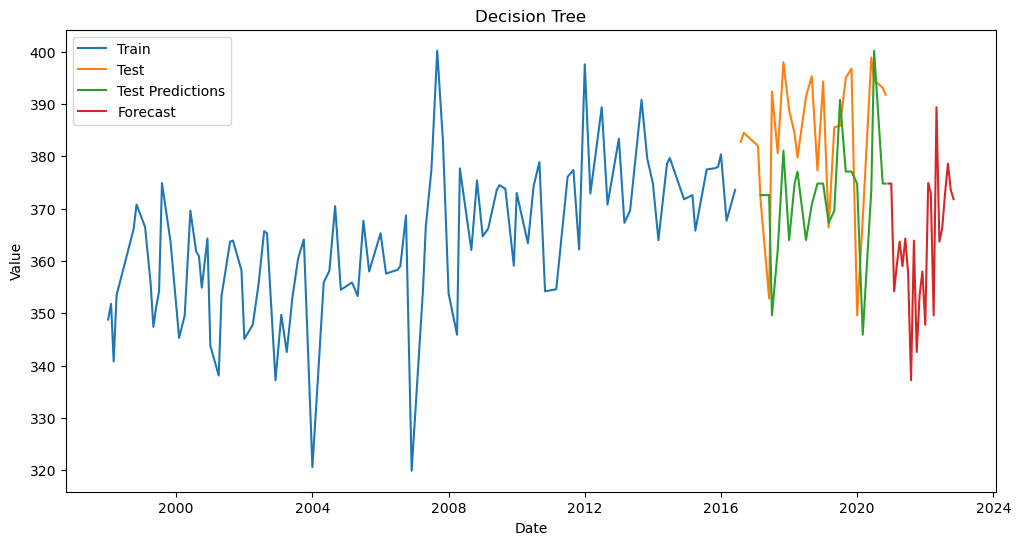

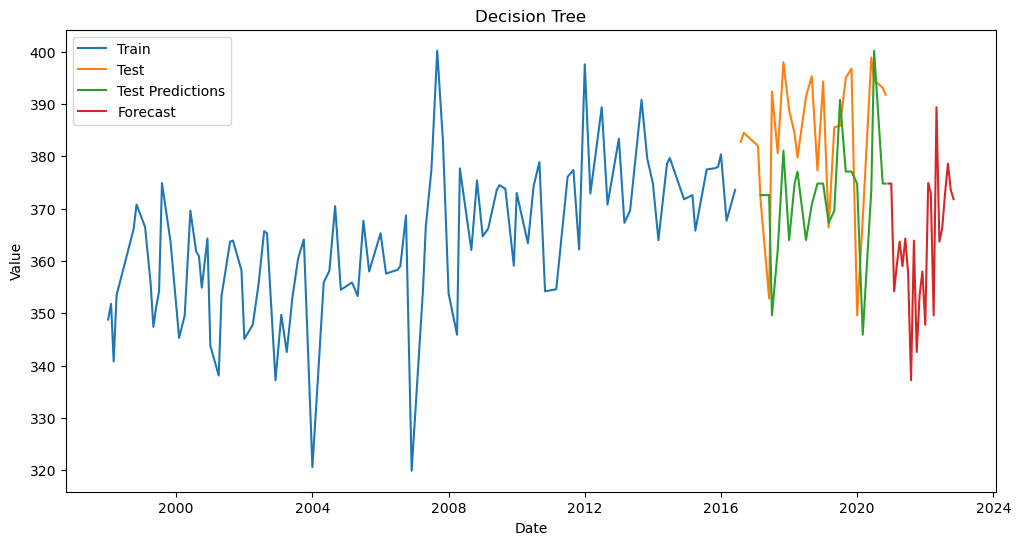

In [215]:
plot_time_series(y_train, y_test, y_pred, y_forecast, "Decision Tree")